In [1]:
"""
Python implementation of the SW1Pers algorithm described in [0]

References
 - [0] SUPPLEMENTARY INFORMATION SW1PerS: Sliding Windows and 1-Persistence Scoring; DiscoveringPeriodicity in Gene Expression Time Series Data

Conventions:
 - point clouds/matrices are stored in ndarrays, where the last index indexes in a pomt coordinate tuple

"""

import random
import math

import numpy as np
from numpy import linalg

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy.interpolate

import dionysus

In [97]:
def moving_average(g, k = 2):
    """calculates the moving average as used in [0].
    f: 1 dimensional numpy array, input feature array
    k: maximum size
    
    in [0], n is called S and i is called
    
    TODO: the paper states the method in general can be used for non uniform sampled values. how can this filter work then??
    TODO: implement in in O(n) and not O(n*k) or in numpy (convolve?)
    """
    n = len(g)
    res = np.empty(n)
    for i in range(n):
        l = min(i, n-i-1, k)
        res[i] = np.sum(g[i-l : i+l+1]) / (2*l+1)
    return res

In [98]:
assert all(moving_average(np.array([1,2,3,4,5]), k=0) == np.array([1,2,3,4,5]))
assert all(moving_average(np.array([1,2,3,4,5]), k=2) == np.array([1, 2, 3, 4, 5]))
assert all(moving_average(np.array([1,2,1,2,1]), k=1) == np.array([1,4/3, 5/3, 4/3, 1]))

In [94]:
def mean_center_normalize(xs):
    """mean centering from [0] along axis 1. step 3 from the SW1Pers pipeline
    xs: two dimensional numpy array.
     axis 0: different points
     axis 1: a point
    
    returned points are on a xs.shape[0] dimensional unit square.
    
    TODO: does this mean centering destroy everything, if there is a constant component in the signal?
        ah ok, as this is a sliding window, mean(x) is a sliding average so this makes sense
    """
    
    xs = xs - np.mean(xs, axis=1)[:,None]
    xs = xs / linalg.norm(xs, axis=1)[:,None]
    return xs

In [107]:
def make_pointcloud(t, g, dim, window_size, num_points):
    """step 2 from the SW1Pers pipeline
    t: times, must be ascending. if the data equidistant, you can set it to np.arange(len(g))
       t and window_size are scaled, so that t[0], t[-1] correspond to 0, 2*PI. then window_size is called w in [0]
    g: time series, data
    dim: dimension, called M+1 in [0]
    window_size: w, scaled with t
    num_points: the number of equidistant samples from SWf used to generate the point cloud
    
    TODO: what are the boundary parameters for splining?
        """
    # rescale t and window_size to 2π
    scale_t = math.tau / (t[-1]-t[0])
    t -= t[0]
    #print(t, scale_t)
    t *= scale_t
    window_size *= scale_t
    window = np.linspace(0, window_size, dim)
    starts = np.linspace(0, math.tau - window_size, num_points)
    f = scipy.interpolate.CubicSpline(t, g)
    return f(window[None, :] + starts[:, None])

In [3]:
cloud = make_pointcloud(np.array([0.,1.,2.]), np.array([0.,1.,0.]), dim=3, window_size = 0.1, num_points = 50)

[0. 1. 2.] 3.141592653589793


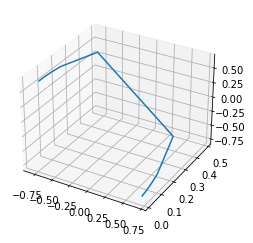

In [68]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(cloud[:,0], cloud[:,1], cloud[:,2])

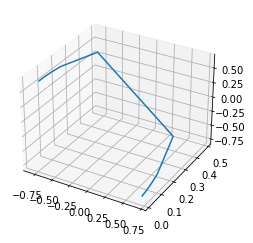

In [66]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cloud = mean_center_normalize(cloud)
ax.plot(cloud[:,0], cloud[:,1], cloud[:,2])

In [81]:
def make_edges(pointcloud, dmax):
    """
    pointcloud: array of points (one point each along axis 1)
    build list [(len, i0, j0,), (len, i1, j1), ...]) of indices belonging to points specifying edges, sorted by length.
    the length is capped to dmax.
    """ 
    # TODO: evaluate and use clever algorithm (space partitioning?) for not calculating all n*n distance squares
    n = len(pointcloud)
    dmat = linalg.norm(pointcloud[:,None,:] - pointcloud[None,:,:], axis = 2)
    edges = []
    for j in range(n):
        for i in range(j):
            if dmat[i,j] <= dmax:
                edges.append((dmat[i,j], i,j))
    edges.sort()
    return edges

In [82]:
es = make_edges(cloud, dmax=0.3)

In [ ]:
es

In [92]:
# currently unused, homologies and rips complex are computed by the library dionysus

class UnionFind:
    """Union-Find Disjoint Set structure with n entries in range(0, n)"""
    def __init__(self, n, randomseed = "thisisnotcryptographicallyimportantbutresultsshouldbereproducible"):
        self.n = n
        self.r = random.Random(randomseed)
        self.parent = list(range(n))
        self.ncomponents = n
    def find(self, i):
        """finds a representant of entry i"""
        p = i
        while p != self.parent[p]:
            p = self.parent[p]
        # path compression. non recursive as python has a very limited stack <3
        while i != self.parent[i]:
            nexti = self.parent[i]
            self.parent[i] = p
            i=nexti
        return p
    def unite(self, i, j):
        """unites the components of i and j.
        return if an new connection was made"""
        if random.randrange(2):
            i,j = j,i
        ii = self.find(i)
        jj = self.find(j)
        self.parent[ii] = jj
        newconnection = ii != jj
        if newconnection:
            self.ncomponents -= 1
        return newconnection

In [100]:
# test
uf = UnionFind(4)
uf.unite(0, 1)
uf.unite(3, 2)
uf.unite(0, 3)
assert uf.ncomponents == 1
assert uf.find(0) == uf.find(1) == uf.find(2) == uf.find(3)

In [101]:
# currently unused, homologies and rips complex are computed by the library dionysus

def uf_label_edges(npoints, edges):
    uf = UnionFind(npoints)
    # if no components are connected, the edge produces a cycle.
    # this is the default, as there can be much more edges than points.
    labels = [1] * len(edges)
    for (ei,(_d, i, j)) in enumerate(edges):
        if uf.ncomponents == 1:
            break # all done, additional edges keep adding cycles
        negative = uf.unite(i,j) # reduction of components
        if negative:
            labels[ei] = -1

In [105]:
def pcscore(pointcloud, dmax, n=2, m=2):
    """sw1pers-score for the pointcloud,
    pointcloud should be an output of mean_center_normalize, as angles are used as distances.
    """
    # disanzen als winkel
    cdm = scipy.spatial.distance.pdist(pointcloud, 'cosine') # 1-cos metric
    cdm = np.arccos(1-cdm) # angles
    # TODO: laesst sich irgendwie scipy.spatial.KDTree.sparse_distance_matrix nutzen?
    # aber wahrscheinlich egal, weil die homologieberechnung die komplexitaet dominiert
    
    fil = dionysus.fill_rips(cdm, k = 2, r = dmax)
    hom = dionysus.homology_persistence(fil)
    # TODO: schauen ob k=2 spezialisiert ist, mit algorithmus aus [0] vergleichen
    
    dgm = dionysus.init_diagrams(hom, fil)[1]
    p = max(dgm, key=lambda p: p.death - p.birth)
    # TODO: warum sind die exponenten so unsymmetrisch?
    return (p.death**n-p.birth**m) / (3**(n/2))

In [108]:
t = np.linspace(0, 5 * math.tau)
fs = np.sin(t)
cloud = make_pointcloud(t, fs, dim=3, window_size=2, num_points=100)
cloud = mean_center_normalize(cloud)

pcscore(cloud, dmax=5)

1.428097320481896

In [98]:
uf.unite(0, 1)

False

In [99]:
uf.ncomponents

3

In [4]:
help(dionysus.fill_rips)

Help on built-in function fill_rips in module dionysus._dionysus:

fill_rips(...) method of builtins.PyCapsule instance
    fill_rips(data: array, k: int, r: float) -> dionysus._dionysus.Filtration
    
    returns (sorted) filtration filled with the k-skeleton of the clique complex built on the points at distance at most r from each other



In [6]:
fil = dionysus.fill_rips(cloud, k=2, r=0.3)

In [7]:
h = dionysus.homology_persistence(fil)

In [8]:
h

Reduced matrix with 2651 columns

In [23]:
ds = dionysus.init_diagrams(h, fil)

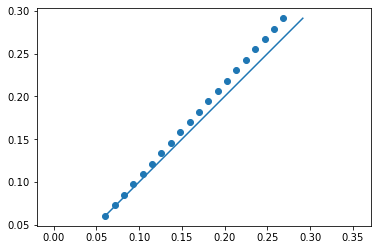

In [27]:
dionysus.plot.plot_diagram(ds[1], show = True)

In [28]:
ds

[Diagram with 50 points, Diagram with 20 points, Diagram with 1816 points]

In [ ]:
help(ds[1])

In [72]:
a = list(ds[1])[0]
list(a)

TypeError: 'dionysus._dionysus.DiagramPoint' object is not iterable

In [45]:
npoints = 200
R = 10
r = 2
def toruspoint(angles):
    theta, phi = angles
    d = R + r*np.cos(theta)
    h = r*np.sin(theta)
    return np.array([d*np.cos(phi), h, d*np.sin(phi)])

angles = np.random.uniform(low = 0, high = math.tau, size = (2, npoints))
points = toruspoint(angles)

In [56]:
fil = dionysus.fill_rips(points.transpose(), k = 3, r = 10)
hom = dionysus.homology_persistence(fil)
dgms = dionysus.init_diagrams(hom, fil)

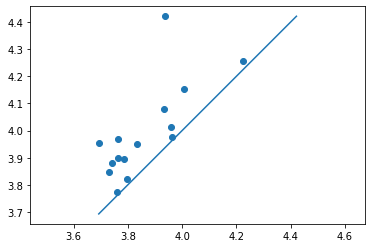

In [61]:
dionysus.plot.plot_diagram(dgms[2], show = True)

In [52]:
help(np.random.uniform)

Help on built-in function uniform:

uniform(...) method of numpy.random.mtrand.RandomState instance
    uniform(low=0.0, high=1.0, size=None)
    
    Draw samples from a uniform distribution.
    
    Samples are uniformly distributed over the half-open interval
    ``[low, high)`` (includes low, but excludes high).  In other words,
    any value within the given interval is equally likely to be drawn
    by `uniform`.
    
    .. note::
        New code should use the ``uniform`` method of a ``default_rng()``
        instance instead; please see the :ref:`random-quick-start`.
    
    Parameters
    ----------
    low : float or array_like of floats, optional
        Lower boundary of the output interval.  All values generated will be
        greater than or equal to low.  The default value is 0.
    high : float or array_like of floats
        Upper boundary of the output interval.  All values generated will be
        less than or equal to high.  The default value is 1.0.
    size 

In [102]:
# summary method, full pipeline

def score(t, g, dim, window_size, cloud_points, timeseries_average_k = 0, score_n=2, score_m=2, dmax = 0.3):
    """SW1Pers-score of time line (t,g).
    t, g, dim, window_size, cloud_points: parameters for make_pointcloud
    timeseries_average_k: k of moving average. with k=0, averaging does nothing.
    score_n, score_m: n,m exponents given to pcscore
    dmax: maximum edge length in rips complex. TODO lookup default value
     
    TODO: take parameter for expected periods, calculate other defaults from it 
    TODO: t,g as one parameter that can have shape (n,) (equidistant) or shape (n,2) (explicit times)
    """
    g = moving_average(g, timeseries_average_k)
    cloud = make_pointcloud(t,g,dim,window_sizecloud_points)
    cloud = mean_center_normalize(cloud)
    return pcscore(cloud, dmax=dmax, n=score_n, m=score_m)

In [ ]:
# TODO: create the test data from the paper to compare results